In [56]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file
import math

In [57]:
# Define the ticker symbol
tickerSymbol = 'NVDA'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00-05:00,13.073095,13.620042,12.556078,13.312275,1925304000,0.0,0.0
2021-01-08 00:00:00-05:00,13.330731,13.927808,13.010993,13.168866,1595496000,0.0,0.0
2021-01-15 00:00:00-05:00,13.196550,13.965967,12.813463,13.834530,1100320000,0.0,0.0
2021-01-22 00:00:00-05:00,13.707333,13.808841,12.763333,13.019971,1261500000,0.0,0.0
2021-01-29 00:00:00-05:00,13.043914,13.898627,12.872074,13.631763,1155944000,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-09 00:00:00-04:00,105.639999,123.239998,103.430000,122.860001,1586383900,0.0,0.0
2024-08-16 00:00:00-04:00,121.940002,130.750000,121.180000,123.739998,1555083600,0.0,0.0
2024-08-23 00:00:00-04:00,125.860001,131.259995,116.709999,117.589996,1859454000,0.0,0.0


In [58]:
max_weeks = 52

In [59]:

gap = (1/100)*100

option_prices = {
    1: [103/3.45],
    2: [103/4.82],
    3: [103/5.75],
    4: [103/6.60],
    5: [103/7.15],
    6: [103/8.00],
    7: [103/8.70],
    10: [103/10.47],
    15: [103/13.30],
    19: [103/16.40],
    24: [103/17.00],
    28: [104/17.60],
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

polygon_data = {
 1: 45.048954161103694,
 2: 28.34645669291339,
 3: 23.078757717985823,
 4: 19.33139534883721,
 5: 17.06700379266751,
 6: 15.620063191153237,
 7: 14.24426477485154,
 8: 13.38747901649057,
 9: 11.738148984198647,
 10: 11.445997569, #12.073272273105745,
 11: 11.153846153846153,
 12: 10.614525139664805,
 13: 9.758771929824562,
 14: 9.537422037422036,
 15: 9.183576410906785,
 16: 8.996728462377318,
 17: 8.391608391608392,
 18: 8.289756220790704,
 19: 8.157389635316699,
 20: 7.906976744186046,
 21: 7.758620689655173,
 22: 7.539353769676885,
 23: 7.381756756756756,
 24: 7.292856343074684,
 25: 7.112068965517242,
 26: 6.854838709677419}

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
# option_leverage = polygon_data
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 1w 29.9
	 2w 21.4
	 3w 17.9
	 4w 15.6
	 5w 14.4
	 6w 12.9
	 7w 11.8
	10w  9.8
	15w  7.7
	19w  6.3
	24w  6.1
	28w  5.9
mean option leverage, break even:
	 1w 29.9  4.3%
	 2w 21.4  5.7%
	 3w 17.9  6.6%
	 4w 15.6  7.4%
	 5w 14.4  7.9%
	 6w 12.9  8.8%
	 7w 11.8  9.4%
	10w  9.8 11.2%
	15w  7.7 13.9%
	19w  6.3 16.9%
	24w  6.1 17.5%
	28w  5.9 17.9%
option gap: 1.00%


In [60]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [61]:
print('Option performance (weeks, profit, positive, w max):')
for p in option_performance:
    weeks = p[0]
    print(f'\t{weeks:2}w {p[1]:4.0f}% {p[2]:3.0f}% {p[3]:4.0f}%')

Option performance (weeks, profit, positive, w max):
	 1w  -13%  32%  -97%
	 2w   12%  39%  -58%
	 3w   31%  43%  -48%
	 4w   41%  44%  -24%
	 5w   56%  42%   -6%
	 6w   62%  47%   -9%
	 7w   70%  49%   -4%
	10w   95%  57%   18%
	15w  130%  60%  155%
	19w  145%  63%  140%
	24w  210%  66%  175%
	28w  257%  71%  238%


In [62]:
from file import save_file

save_file(tickerSymbol, option_performance)

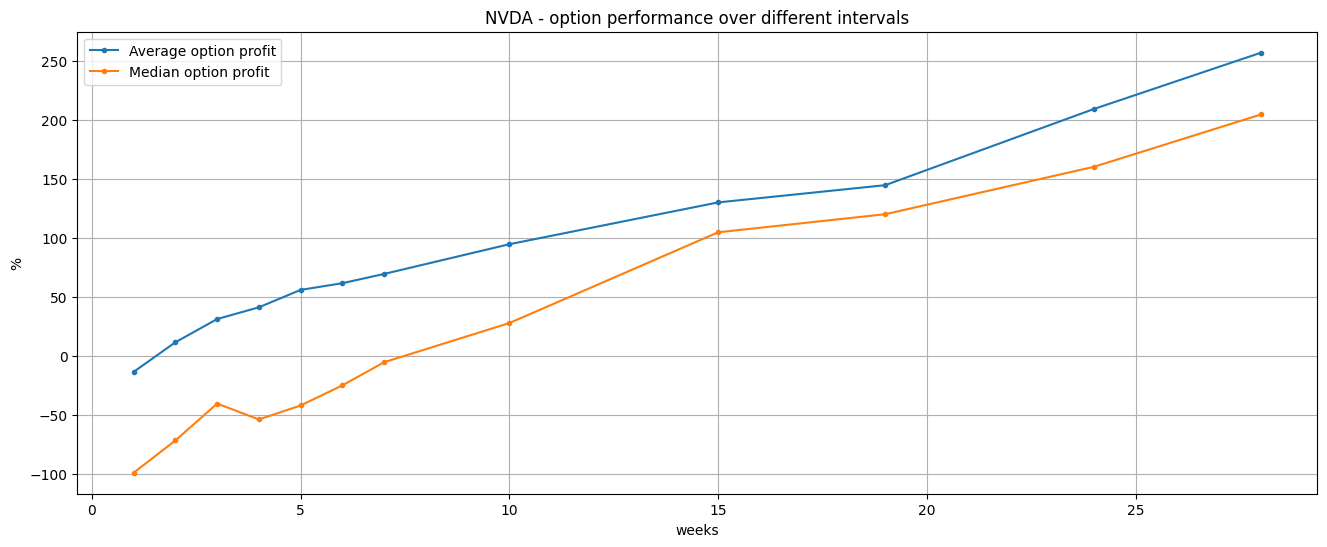

In [63]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_mprofit = [p[4] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
# plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.plot(option_weeks, option_mprofit, label='Median option profit', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

In [64]:
weeks = 4
history['stock_change'] = history['Close'].pct_change(periods=weeks) * 100
history['whigh'] = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
lvr = option_leverage[weeks]
history['wmax_profit'] = (((history['whigh'] / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)


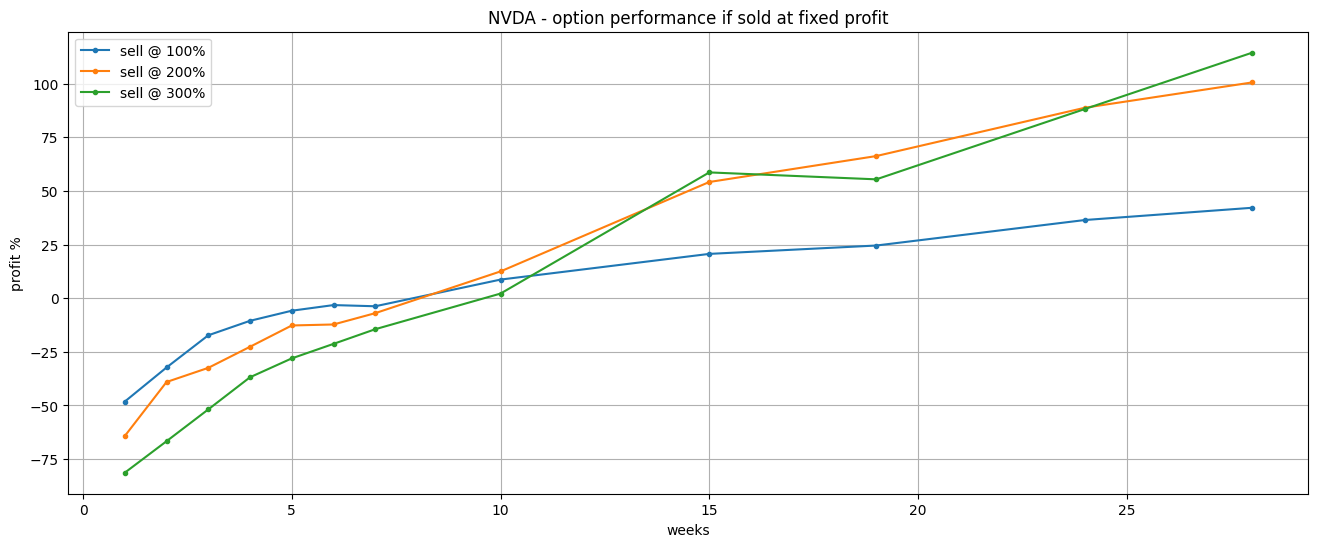

In [65]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

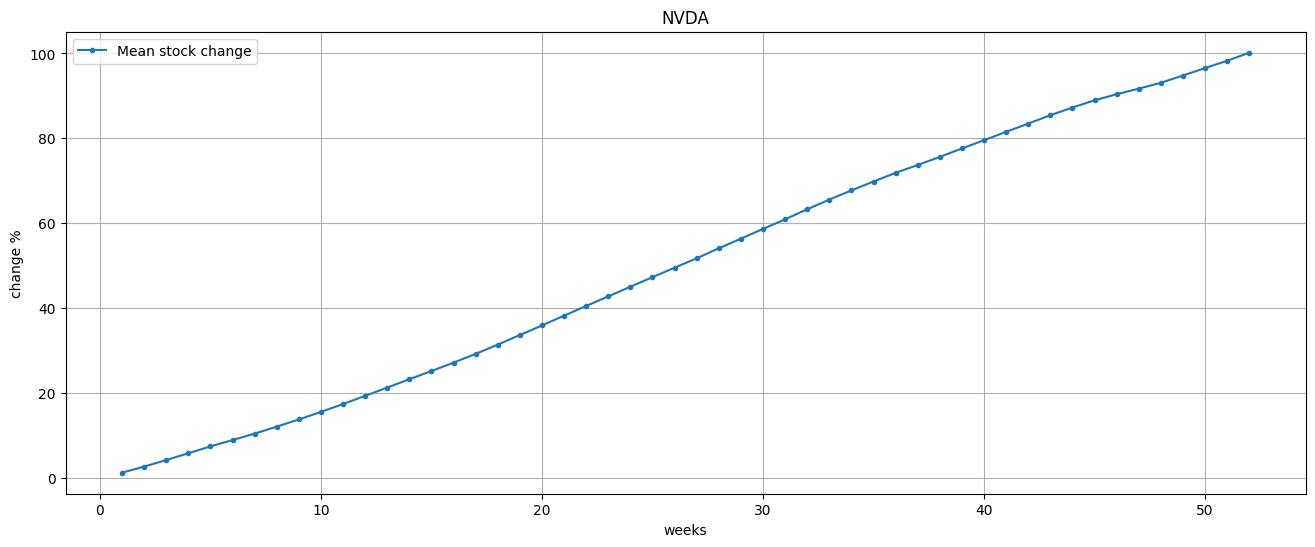

In [66]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Mean stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()

In [67]:
for i, v in enumerate(stock_change[1:], start=1):
  print(f'{i:2d}w {v:5.1f}% {math.sqrt(1+v/100)-1:6.1%}')

 1w   1.3%   0.7%
 2w   2.8%   1.4%
 3w   4.3%   2.1%
 4w   5.9%   2.9%
 5w   7.5%   3.7%
 6w   9.0%   4.4%
 7w  10.5%   5.1%
 8w  12.2%   5.9%
 9w  13.8%   6.7%
10w  15.6%   7.5%
11w  17.5%   8.4%
12w  19.4%   9.3%
13w  21.3%  10.2%
14w  23.3%  11.0%
15w  25.2%  11.9%
16w  27.2%  12.8%
17w  29.3%  13.7%
18w  31.5%  14.7%
19w  33.7%  15.6%
20w  36.0%  16.6%
21w  38.3%  17.6%
22w  40.6%  18.6%
23w  42.8%  19.5%
24w  45.1%  20.5%
25w  47.3%  21.4%
26w  49.6%  22.3%
27w  51.8%  23.2%
28w  54.1%  24.2%
29w  56.4%  25.1%
30w  58.7%  26.0%
31w  61.0%  26.9%
32w  63.3%  27.8%
33w  65.6%  28.7%
34w  67.8%  29.5%
35w  69.8%  30.3%
36w  71.9%  31.1%
37w  73.7%  31.8%
38w  75.7%  32.5%
39w  77.6%  33.3%
40w  79.6%  34.0%
41w  81.5%  34.7%
42w  83.5%  35.5%
43w  85.5%  36.2%
44w  87.3%  36.8%
45w  89.0%  37.5%
46w  90.4%  38.0%
47w  91.7%  38.5%
48w  93.1%  39.0%
49w  94.8%  39.6%
50w  96.6%  40.2%
51w  98.3%  40.8%
52w 100.2%  41.5%


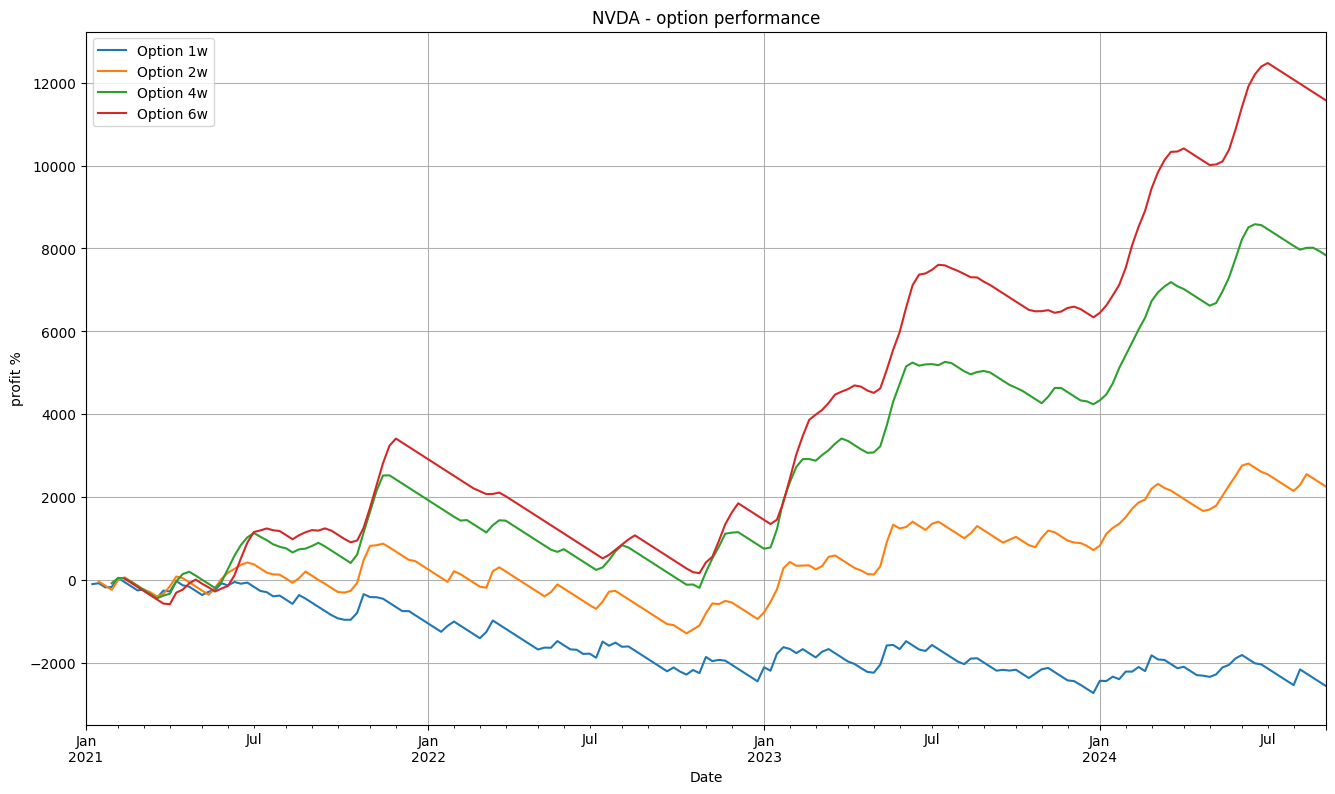

In [69]:
plt.figure(figsize=(16,9))

for w in [1,2,4,6]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('profit %')
plt.grid()
plt.show()


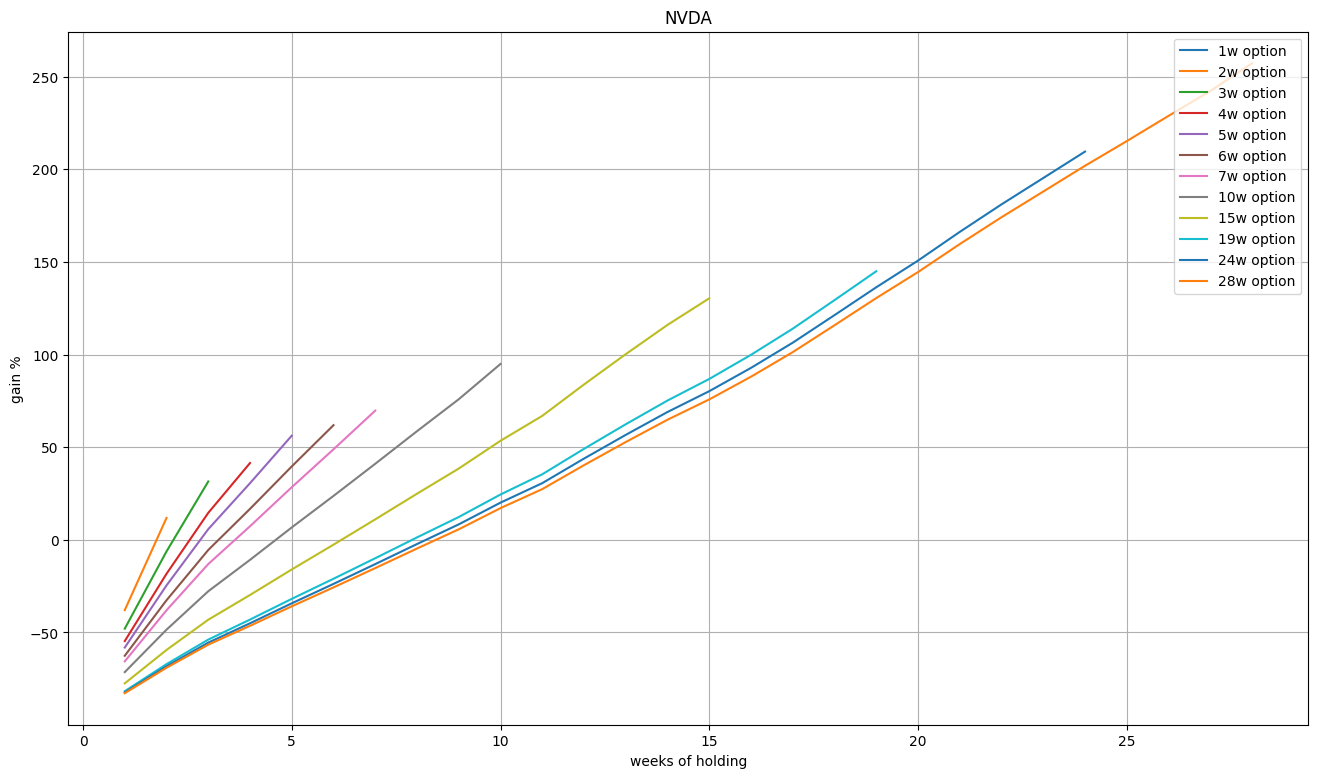

In [70]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = [None]
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain %')
plt.grid()
plt.show()